# Loading/Downlading Packages

In [ ]:
!pip install --quiet ftfy regex tqdm
!pip install --quiet git+https://github.com/openai/CLIP.git
!pip install --quiet pycocotools
from zipfile import ZipFile
from google.colab import drive
import numpy as np
import os
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pycocotools.coco import COCO
from torchvision import transforms, datasets
from torchvision.datasets import CocoCaptions
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import clip

  Preparing metadata (setup.py) ... done


# Unzipping MSOCO Data (2014)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
gdrive_dir = '/content/drive/MyDrive/coco2014'  # Google Drive directory
data_dir = '/content/coco2014'
os.makedirs(data_dir, exist_ok=True)

# Dataset names
data = ["train2014", "val2014", "annotations_trainval2014"]

# Extract datasets from Google Drive
for name in data:
    zip_path = os.path.join(gdrive_dir, f"{name}.zip")
    print(f"Processing {name}...")

    if os.path.exists(zip_path):
        # Unzip the dataset to the local directory
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"{name} extracted to local directory.")
    else:
        print(f"Zip file for {name} not found in Google Drive at {zip_path}.")

print("All available datasets successfully extracted to local directory!")


Mounted at /content/drive
Processing train2014...
train2014 extracted to local directory.
Processing val2014...
val2014 extracted to local directory.
Processing annotations_trainval2014...
annotations_trainval2014 extracted to local directory.
All available datasets successfully extracted to local directory!


# Evaluation Technique (Recall @ K)

## Constructing Recall @ K Function

In [ ]:
def recall_at_k(image_embeddings, caption_embeddings, img_to_caption_map, k_vals):
    # Compute similarity matrix
    # Can augment this code to compute different types of similarity
    dist_matrix = image_embeddings @ caption_embeddings.T  # dot product simlarity scores
    dist_matrix = dist_matrix.cpu()

    # Sort captions by similarity
    inds = torch.argsort(dist_matrix, dim=1, descending=True)
    inds = inds.to(image_embeddings.device)

    recall_scores = []

    for k in k_vals:
        topk = inds[:, :k]  # Top-K indices for each image

        # Verify if top-K contains any of the ground truth captions
        correct_matches = torch.zeros((image_embeddings.size(0),), dtype=torch.bool).to(image_embeddings.device)
        for img_idx in range(image_embeddings.size(0)):
            ground_truth_indices = torch.nonzero(img_to_caption_map == img_idx).squeeze(-1)
            correct_captions = torch.isin(topk[img_idx], ground_truth_indices)
            if correct_captions.any():
                correct_matches[img_idx] = True

        num_correct = correct_matches.sum().item()
        recall_scores.append(num_correct / image_embeddings.size(0))

    return recall_scores

# Prepare the MSCOCO Data Loaders

## Load the Teacher Model: OpenAI CLIP RN50 Model

In [ ]:
train_root = "/content/coco2014/train2014"
train_ann_file = "/content/coco2014/annotations/captions_train2014.json"

val_root = "/content/coco2014/val2014"
val_ann_file = "/content/coco2014/annotations/captions_val2014.json"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

clip_model, preprocess = clip.load("RN50", device)
clip_model.eval()

input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 244M/244M [00:07<00:00, 32.8MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Adjusting Training Subset

In [ ]:
# COCO dataset loading
class CocoCaptionsDataset(Dataset):
    def __init__(self, root, annFile, transform=None, context_length=77):
        self.dataset = datasets.CocoCaptions(root=root, annFile=annFile, transform=transform)
        self.transform = transform
        self.context_length = context_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, captions = self.dataset[idx]
        text = clip.tokenize(captions[:5], context_length=self.context_length)  # Use up to 5 captions
        return image, text

# Load dataset
dataset = CocoCaptionsDataset(root=val_root, annFile=val_ann_file, transform=preprocess) # CHANGE THIS IF YOU WANT TO USE VALIDATION SET

def create_subset(data, size):
    indices = random.sample(range(len(data)), size)
    return torch.utils.data.Subset(data, indices)

subset_size = 10000
subset_dataset = create_subset(dataset, subset_size)

# DataLoader
data_loader = DataLoader(
    subset_dataset, batch_size=16, shuffle=True, num_workers=4  # Increased num_workers for faster data loading
)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


# Naive/Random Model

In [ ]:
class NaiveBaselineEncoder:
    def __init__(self, embedding_dim, num_captions, device):
        self.embedding_dim = embedding_dim
        self.num_captions = num_captions
        self.device = device

    def encode_image(self, num_images):
        return torch.rand((num_images, self.embedding_dim), device=self.device)

    def encode_text(self, num_images):
        return torch.rand((num_images * self.num_captions, self.embedding_dim), device=self.device)

    def encode_dataset(self, loader):
        num_images = len(loader.dataset)
        image_embeddings = self.encode_image(num_images)
        text_embeddings = self.encode_text(num_images)

        # Construct a simple caption-to-image mapping
        caption_to_img_map = torch.arange(num_images, device=self.device).repeat_interleave(self.num_captions)

        return image_embeddings, text_embeddings, caption_to_img_map

In [ ]:
# Instantiate the Naive Baseline Encoder
embedding_dim = 1024
num_captions = 5
naive_encoder = NaiveBaselineEncoder(embedding_dim=embedding_dim, num_captions=num_captions, device=device)

# Encode dataset using the naive baseline
naive_image_embeddings, naive_text_embeddings, caption_to_img_map = naive_encoder.encode_dataset(data_loader)

## Naive Model (Random) Performance

In [ ]:
# Evaluate Recall@K
k_vals = [1, 3, 5]
naive_recall = recall_at_k(naive_image_embeddings, naive_text_embeddings, caption_to_img_map, k_vals)

# Display Recall@K Results
print("Recall@K Results (Naive Baseline Encoder):")
for k, score in zip(k_vals, naive_recall):
    print(f"Recall@{k}: {score * 100:.2f}%")

Recall@K Results (Naive Baseline Encoder):
Recall@1: 0.01%
Recall@3: 0.02%
Recall@5: 0.04%


# Teacher Model (ResNet-50)

In [ ]:
class TeacherModelEncoder:
    def __init__(self, clip_model, device):
        self.clip_model = clip_model
        self.device = device

    def encode_dataset(self, loader):
        with torch.no_grad():
            image_embeddings, text_embeddings = [], []
            caption_to_img_map = []

            for batch_idx, (images, texts) in enumerate(loader):
                images = images.to(self.device)
                texts = texts.to(self.device)

                # Encode images and text
                batch_img_embeds = self.clip_model.encode_image(images)
                batch_txt_embeds = self.clip_model.encode_text(texts.flatten(0, 1))  # Flatten all captions

                image_embeddings.append(batch_img_embeds)
                text_embeddings.append(batch_txt_embeds)

                # Generate caption-to-image mapping
                batch_size = images.size(0)
                captions_per_image = texts.size(1)
                for img_idx in range(batch_size):
                    caption_to_img_map.extend([batch_idx * batch_size + img_idx] * captions_per_image)

            # Concatenate and normalize embeddings
            image_embeddings = torch.cat(image_embeddings)
            text_embeddings = torch.cat(text_embeddings)
            image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
            text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

            caption_to_img_map = torch.tensor(caption_to_img_map, device=self.device)

        return image_embeddings, text_embeddings, caption_to_img_map

teacher_encoder = TeacherModelEncoder(clip_model, device)
teacher_image_embeddings, teacher_text_embeddings, caption_to_img_map = teacher_encoder.encode_dataset(data_loader)

## Pre-trained Teacher (ResNet-50) Performance

In [ ]:
# Recall@K Evaluation
k_vals = [1, 3, 5]
teacher_recall = recall_at_k(teacher_image_embeddings, teacher_text_embeddings, caption_to_img_map, k_vals)

print("Recall@K for Teacher Model (ResNet50):")
for k, score in zip(k_vals, teacher_recall):
    print(f"Recall@{k}: {score * 100:.2f}%")

Recall@K for Teacher Model (ResNet50):
Recall@1: 39.95%
Recall@3: 57.38%
Recall@5: 64.89%


# Example of Teacher Model Prediction

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


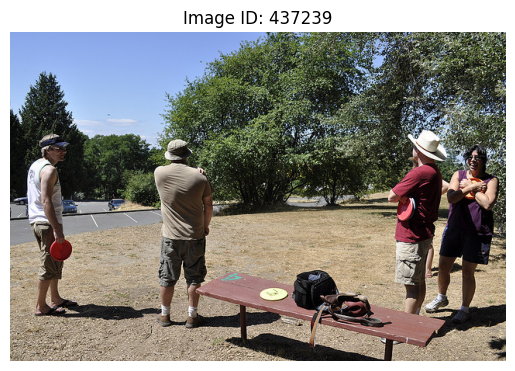


Ground Truth Captions:
- A group of people standing on a field playing disc golf.
- A group of people stand next to a bench outside.
- A group of people standing beside a bench with frisbees.
- Three men and a woman in the park with frisbees. 
- A group of people who are outside holding a Frisbee.

Top 5 Predicted Captions:
1. A photograph of an individual being taken in this picture. 
 (Similarity: 5.3164)
2. A pair of people stand and talk and play on a phone. (Similarity: 5.0547)
3. Photographing what appears to be a form of entertainment. (Similarity: 5.0117)
4. People engaging in activities in an open area.  (Similarity: 5.0039)
5. Some people posting in front of a camera for a picture.  (Similarity: 4.9766)


In [ ]:
def display_teacher_predictions(image_id, teacher_model, coco_val, val_images_dir, preprocess, batch_size=256):
    """
    Display a random image from the dataset, its ground truth captions, and the top predictions from the teacher model.
    """
    # Load the image metadata and ground truth captions
    image_metadata = coco_val.loadImgs([image_id])[0]
    ground_truth_captions = [
        ann['caption'] for ann in coco_val.loadAnns(coco_val.getAnnIds(imgIds=[image_id]))
    ]

    # Load and preprocess the image
    image_path = os.path.join(val_images_dir, image_metadata['file_name'])
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return

    img = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(img).unsqueeze(0).to(device)  # Preprocess and add batch dimension

    # Generate teacher image embedding
    with torch.no_grad():
        teacher_image_embedding = teacher_model.encode_image(image_tensor)

    # Process all captions in batches
    all_captions = [ann['caption'] for ann in coco_val.loadAnns(coco_val.getAnnIds())]
    teacher_caption_embeddings = []
    for i in range(0, len(all_captions), batch_size):
        batch_captions = all_captions[i:i + batch_size]
        tokenized_captions = clip.tokenize(batch_captions).to(device)
        with torch.no_grad():
            batch_embeddings = teacher_model.encode_text(tokenized_captions)
        teacher_caption_embeddings.append(batch_embeddings)
    teacher_caption_embeddings = torch.cat(teacher_caption_embeddings, dim=0)

    # Compute similarities and retrieve top captions
    similarities = (teacher_image_embedding @ teacher_caption_embeddings.T).squeeze(0)
    top_k_indices = torch.argsort(similarities, descending=True)[:5]
    top_k_captions = [all_captions[idx] for idx in top_k_indices.cpu().numpy()]

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image ID: {image_id}")
    plt.show()

    # Print ground truth captions and predictions
    print("\nGround Truth Captions:")
    for caption in ground_truth_captions:
        print(f"- {caption}")

    print("\nTop 5 Predicted Captions:")
    for idx, caption in enumerate(top_k_captions):
        print(f"{idx + 1}. {caption} (Similarity: {similarities[top_k_indices[idx]]:.4f})")

val_images_dir = os.path.join(data_dir, 'val2014')
val_annotations_file = os.path.join(data_dir, 'annotations/captions_val2014.json')

# train_ann_file
# val_ann_file
coco_data = COCO(val_ann_file) #change
# Select a random image ID
random_image_id = random.choice(coco_data.getImgIds())

# Display the random image with naive predictions and ground truth captions

display_teacher_predictions(
    image_id=random_image_id,
    teacher_model=clip_model,  # Use the teacher model (CLIP RN50)
    coco_val=coco_data,
    val_images_dir=val_root,
    preprocess=preprocess,
    batch_size=256  # Process captions in batches of 256
)